<a href="https://colab.research.google.com/github/ernestoaddiego/FinanceMachineLearning/blob/master/StockPredictUsingML_EAG_06Sep19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Algo Trading and Finance using Machine Learning (in Python)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1M_XKmYlfHSaVRBco-2Ta79Hz5RApUx1G)

By: [Ernesto Addiego-Guevara](https://www.linkedin.com/in/ernestoaddiego/)

*Resource:* https://www.datacamp.com/community/tutorials/finance-python-trading

**Intent** 

Demonstrating the application of python programming and machine learning techniques on algorthmic trading and stock price predictions.

I modified the tutorial from [DataCamp](https://www.datacamp.com/community/tutorials/finance-python-trading) to do Exploratory Financial Analysis and build two trading strategies. 

**Outline**
- Importing Data
- Common Financial Analyses
- Building a Trading Strategy w. Python
  - Moving Average Crossover
- Predicting stock prices with Machine Learning 

First, I import the necessary packages we need.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


## Importing Data

A method to download data is to use the quoted `pandas_datareader` package and the `fix_yahoo_finance` as shown in the [DataCamp tutorial](https://www.datacamp.com/community/tutorials/finance-python-trading)

In [2]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

bp = pdr.get_data_yahoo('BP.L',
                         start=datetime.datetime(2010,6,1),
                         end=datetime.datetime(2019,8,31))
bp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-01,446.350006,411.500000,440.0,430.000000,227283291.0,262.656952
2010-06-02,431.899994,415.100006,418.0,429.750000,123311927.0,262.504303
2010-06-03,450.049988,431.100006,440.0,432.250000,113817392.0,264.031342
2010-06-04,452.750000,432.500000,450.0,433.350006,98458965.0,264.703247
2010-06-07,448.000000,427.549988,430.0,430.299988,87928589.0,262.840179


*Note:* I selected this period as I know it reflects a period that this share price was rebalanced post the Deepwater Horizon accident.

*Note 2:* In the future, one may need to use the latest YahooFinancials data module from [PyPI](https://pypi.org/project/yahoofinancials/)

As the current `fix_yahoo_finance` module from `pandas_datareader` may not work.

## Working with Time Series Data

First, let's complete a few basic evaluation of the downloaded dataset. And plot a few key features.

In [3]:
# Sample 20 rows
sample = bp.sample(20)

# Print `sample`
print(sample)

# Resample to monthly level 
monthly_bp = bp.resample('M')

# Print `monthly_aapl`
print(monthly_bp)

                  High         Low  ...      Volume   Adj Close
Date                                ...                        
2012-02-15  499.713013  483.100006  ...  24792131.0  312.546967
2014-11-21  450.799988  442.763000  ...  30718121.0  329.566254
2017-09-26  476.096985  470.113007  ...  31447121.0  419.401794
2014-06-19  519.044006  515.250000  ...  21077322.0  369.088440
2016-09-29  453.250000  447.730011  ...  45738066.0  374.443390
2017-07-17  451.000000  446.000000  ...  25593317.0  391.847961
2014-09-25  463.750000  450.149994  ...  54816540.0  327.400330
2013-10-07  439.149994  433.950012  ...  15222146.0  303.023712
2011-07-04  464.149994  459.000000  ...  13287127.0  287.983307
2017-06-20  475.630005  459.399994  ...   4126758.0  402.697327
2018-09-13  554.400024  547.500000  ...  29324419.0  516.648132
2014-08-06  478.100006  473.049988  ...  38584512.0  343.270386
2013-05-23  480.600006  473.899994  ...  38448578.0  325.714874
2012-11-28  431.950012  418.700012  ... 

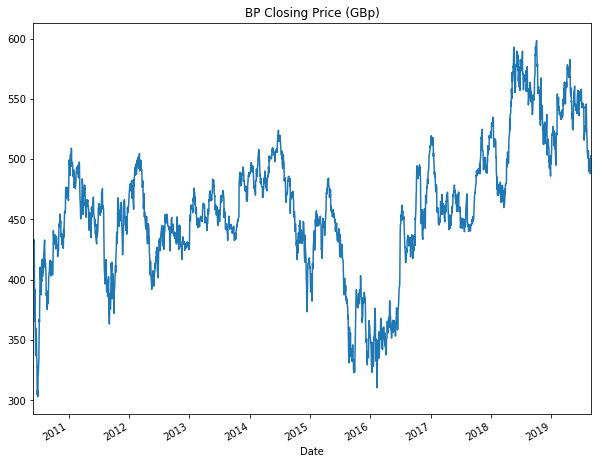

In [4]:
# Plot the closing prices for `bp`
bp['Close'].plot(grid=False, figsize=(10,8),title='BP Closing Price (GBp)')

# Show the plot
plt.show()

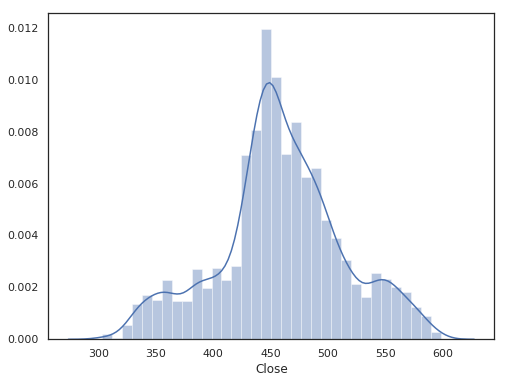

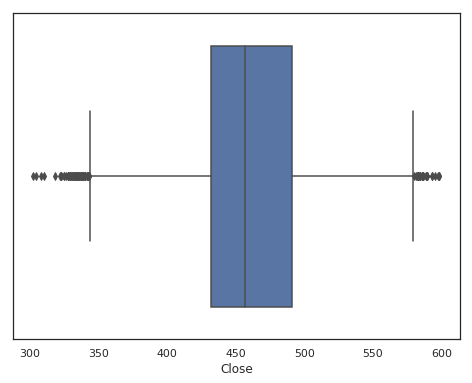

In [5]:
# then create a variable data w. data from column 'Close'
Close = bp['Close']

# a few styles formatting
sns.set(style="white")

# plot a distplot from seaborn
plt.figure(figsize=(8,6))
sns.distplot(Close)

# plot a boxplot from seaborn
plt.figure(figsize=(8,6))
sns.boxplot(Close)

*Reflection:* In its simplest form, I would program an algo trading to recommend to:
1. **Short/Sell** if the share price is greater than the mean+1Sigma.
2. **Hold** if the share price is within +/- a quartile from the mean.
3. **Long/Buy** if the share price is lower than the mean-1Sigma.

Finally, let's estimate a few more stats on the Close price.

In [6]:
# First, the mean
print ("\nMeans (pandas):\n")
print(Close.mean())

# then the sigma
print ("\nStd (pandas):\n")
print (Close.std())

# Estimating Min, Max, P10, P50, P90
print("\nMin (pandas):\n")
print(Close.min())

print("\nMax (pandas):\n")
print(Close.max())

print("\nP10 (pandas):\n")
print(Close.quantile(0.10))

print("\nP90 (pandas):n")
print(Close.quantile(0.90))


Means (pandas):

458.933581571685

Std (pandas):

54.91895413538307

Min (pandas):

302.8999938964844

Max (pandas):

598.2999877929688

P10 (pandas):

384.2799957275391

P90 (pandas):n
536.0299926757813


## Common Financial Analysis



In-depth analyses:
* Returns
  * Moving windows
* Correlations with peers
  * Volatility calculation


### Returns

Including:
* Daily returns
* Daily log returns
* Monthly % change
* Quaterly % change

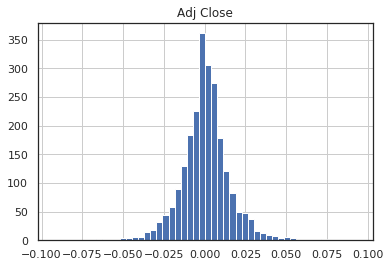

         Adj Close
count  2338.000000
mean      0.000387
std       0.014910
min      -0.093008
25%      -0.007252
50%       0.000115
75%       0.007634
max       0.093613


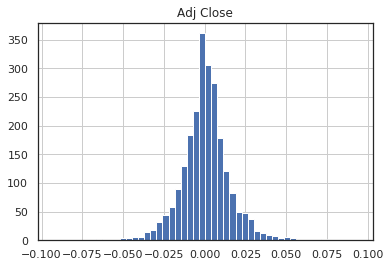

         Adj Close
count  2338.000000
mean      0.000387
std       0.014910
min      -0.093008
25%      -0.007252
50%       0.000115
75%       0.007634
max       0.093613


In [7]:
# Assign `Adj Close` to `daily_close`
daily_close = bp[['Adj Close']]

# Daily returns
daily_pct_c = daily_close.pct_change()

# Replace NA values with 0
daily_pct_c.fillna(0, inplace=True)

# Plot the distribution of `daily_pct_c`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Plot the distribution of `daily_log_returns`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

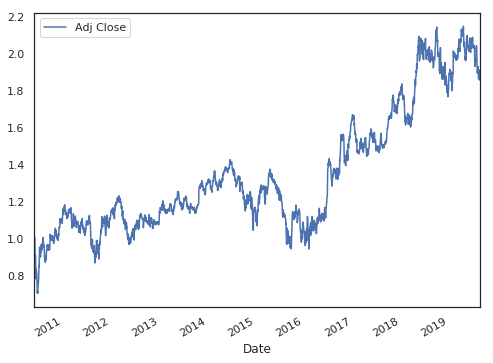

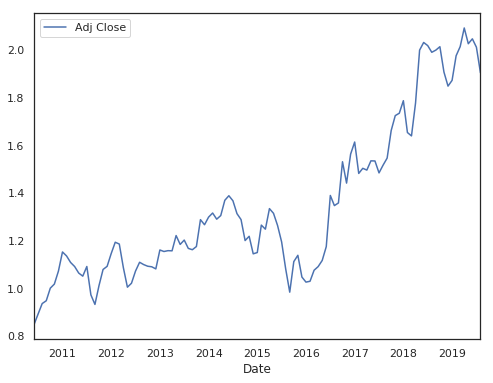

In [8]:
# Now compute the daily returns
# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_c).cumprod()

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(8,6))

# Show the plot
plt.show()

# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Plot the cumulative daily returns
cum_monthly_return.plot(figsize=(8,6))

# Show the plot
plt.show()

#### Moving Average Windows

Considering two windows: short (ca. 42 days) and long (ca. 252 days)

*Self Note:* Here is another opportunity to build an auto algo trader. Key insight: compute the first derivatives of the long moving average. Actions when derivative is:
* Positive: *Long* stock. Capture extra gains with a short-stop.
* Zero/Inflexion point: prepare for next action... 
  * if derivative was >0 beforehand, then *Sell/Short* stock
  * if derivative was <0 beforehand, then *Buy/Long* stock
* Negative: *Short* stock.

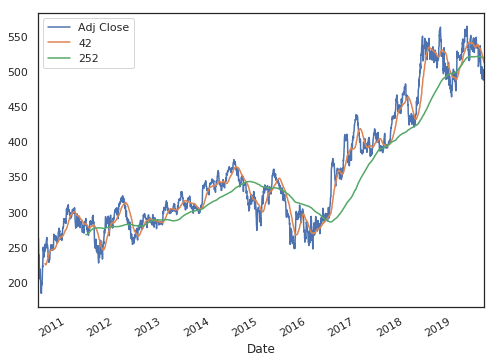

In [9]:
# Isolate the adjusted closing prices 
adj_close_px = bp['Adj Close']

# Short moving window rolling mean
bp['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
bp['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
bp[['Adj Close', '42', '252']].plot(figsize=(8,6))

plt.show()

### Correlation versus the peers

Here we compare the stock of *bp* versus its peers (inclduding XOM, CVX, RDS, TOT)

In [10]:
def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['BP.L', 'RDSB.L', 'XOM', 'CVX','TOT']
all_data = get(tickers, datetime.datetime(2009, 1, 1), datetime.datetime(2019, 9, 1))
all_data.head()

High     Low    Open   Close      Volume   Adj Close
Ticker Date                                                              
BP.L   2009-01-02  553.50  524.50  532.75  552.75  25346686.0  310.145416
       2009-01-05  566.50  546.00  560.00  560.00  47203536.0  314.213440
       2009-01-06  565.00  550.00  560.00  554.50  49070574.0  311.127319
       2009-01-07  546.00  520.25  545.75  523.75  71650181.0  293.873657
       2009-01-08  533.75  515.00  518.00  532.00  36049644.0  298.502716

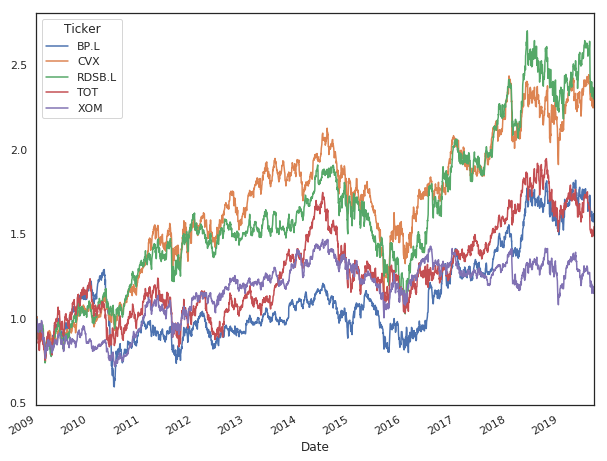

In [11]:
# estimate the daily close vectors
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date','Ticker','Adj Close')

# Estimate the daily percent change for 'daily_close_px'
daily_pct_change = daily_close_px.pct_change()

# estimate the cumulative daily returns
cum_daily_return_px = (1+daily_pct_change).cumprod()

# plot the price trends for all the peers
cum_daily_return_px.plot(figsize=(10,8))
plt.show()

Three clear groups - post oil recession in 2014 - 2016: 
* Winners: RDS & CVX
* Middle pack: BP & TOT
* Bottom pack: XOM

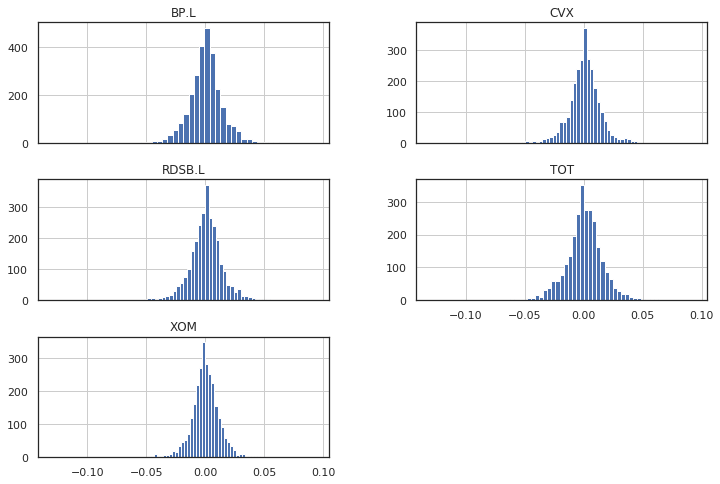

In [12]:
# Now show the distributions of the daily returns of each company stock
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

The returns spread for these energy stocks are very similar.

XOM is an outlier: with negative mean return overall in the last 10 years.

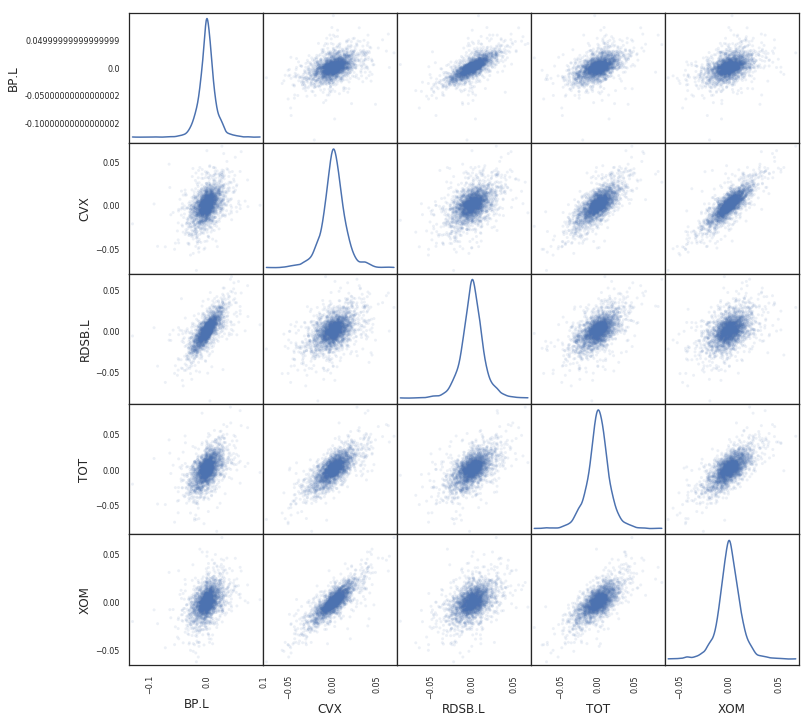

In [13]:
# And now show a scatter matrix that correlates the 'daily_pct_change' data
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))
plt.show()

#### Volatility Calculation
Using the standard deviation of each stock

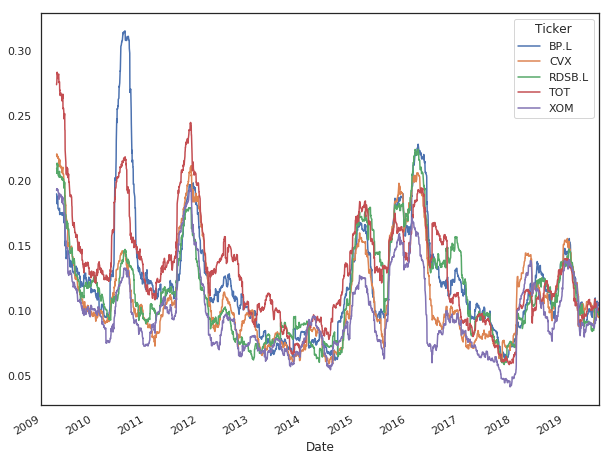

In [14]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

The above plot shows how highly correlated the energy stocks are.

Few historical context:
* 2009: volatility high post-financial crisis
* 2010 2Q: Deepwater Horizon incident for BP
* 2012: Oil price above 100 usd/boe
* 2015 - 2017: oil price recession - rebasing to now 50 +/- 10 usd/boe

The next analyses will build a regression model between two end-members, namely: BP & RDS.

#### Ordinary Least-Square (OLS) Regression between two-pairs of stocks.

In [15]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm
from pandas import tseries

# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Isolate the BP.L returns 
bp_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'BP.L']
bp_returns.index = bp_returns.index.droplevel('Ticker')

# Isolate the RDSB.L returns
shell_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'RDSB.L']
shell_returns.index = shell_returns.index.droplevel('Ticker')

# Build up a new DataFrame with BP.L and RDSB.L returns
return_data = pd.concat([bp_returns, shell_returns], axis=1)[1:]
return_data.columns = ['BP.L', 'RDSB.L']

# Add a constant 
X = sm.add_constant(return_data['BP.L'])

# Construct the model
model = sm.OLS(return_data['RDSB.L'],X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 RDSB.L   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     2617.
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:41:15   Log-Likelihood:                 8541.6
No. Observations:                2693   AIC:                        -1.708e+04
Df Residuals:                    2691   BIC:                        -1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.014      0.3

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


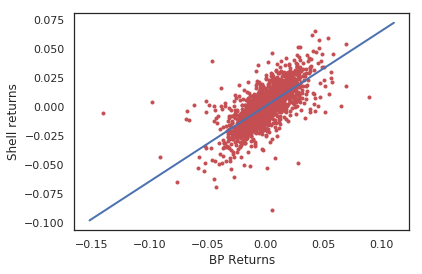

In [16]:
# A cross-plot showing the OLS regression between these two stocks
plt.plot(return_data['BP.L'], return_data['RDSB.L'], 'r.')

ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)

plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

plt.grid(False)
plt.axis('tight')
plt.xlabel('BP Returns')
plt.ylabel('Shell returns')

plt.show()

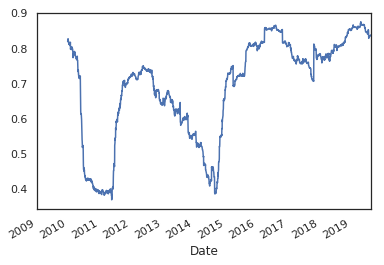

In [17]:
# And the correlation between these stocks over time...
return_data['RDSB.L'].rolling(window=252).corr(return_data['BP.L']).plot()
plt.show()

*Historical Context:*
Three marked periods include:
* 2010 2Q: BP's deepwater horizon incident. RDS & BP stock price diverge.
* 2012 - 2015: high oil price above 100 usd/boe. Stock pair prices start to diverge.
* 2015: Shell announces merger with BG Group. Paired stock price diverge.
* 2016 - 2019: stock prices highly correlated. Driven primarily by hydrocarbon pricing stability.

## An Algorithmic Trading Strategy with Python

This demo will develop the 'classic' trading strategy of the [**moving average crossover**](https://commodity.com/technical-analysis/ma-simple/), i.e. the intersection between short and long moving averages. And this is the simplest algorithmic trading strategy. 

The section after this one will use two different *machine learning* techniques to **predict** the stock prices.

Here is an extract from the [Finance Tutorial in Datacamp](https://www.datacamp.com/community/tutorials/finance-python-trading) - which this notebook is based on.

***
The **moving average crossover**: create two separate Simple Moving Averages (SMA) of a time series with differing lookback periods, let’s say, 40 days and 100 days. If the short moving average (STMA) exceeds the long moving average (LTMA) then you go long (i.e. *buy* the stock); if the long moving average (LTMA) exceeds the short moving average (STMA) then you exit (i.e. *sell* the stock). In short:
* If STMA > LTMA, then *Buy*
* If LTMA > STMA, then *Sell*
***

*Please note*: this demo offers a simplified version of a code that is easy to walk-through. [Halls-Moore (2014)](https://s3.amazonaws.com/quantstart/media/powerpoint/an-introduction-to-backtesting.pdf) built a more robust framework using object-oriented design with classes, etc.

### Building the SMA strategy

In [18]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=bp.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = bp['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = bp['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals: this is the key line of the algorithm
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

signals.head()

,signal,short_mavg,long_mavg,positions
Date,,,,
2010-06-01,0.0,430.000000,430.000000,NaN
2010-06-02,0.0,429.875000,429.875000,0.0
2010-06-03,0.0,430.666667,430.666667,0.0
2010-06-04,0.0,431.337502,431.337502,0.0
2010-06-07,0.0,431.129999,431.129999,0.0


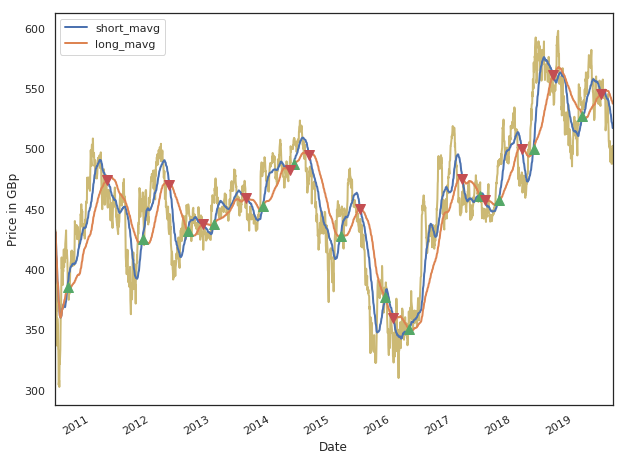

In [19]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in GBp')

# Plot the closing price
bp['Close'].plot(ax=ax1, color='y', lw=2., figsize=(10,8))

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals: i.e. triangles going 'up', coloured green
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g')
         
# Plot the sell signals: i.e. triangles going 'down', coloured red
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r')
         
# Show the plot
plt.show()

### Implementation of a simple Backtester in Python's Pandas

This assumes that the algo trader is allowed to trade with 1000 shares of the stock *bp*, with an initial investment of circa £4300 (GBP) in 1st June 2010.

In [20]:
# Set the initial capital in pences (GBp); note: this is NOT in sterling pounds (GBP)
# Initial capital is £0 (GBP)
initial_capital= float(0.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy 1000 shares
positions['bp'] = 1000*signals['signal']   
  
# Initialize the portfolio with value owned
# Note, shares in FTSE london are recorded in pences, not in pounds
portfolio = positions.multiply(bp['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(bp['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(bp['Adj Close'], axis=0)).sum(axis=1).cumsum()  

# Add `total` to portfolio (in GBp), and compute back to sterling pounds (GPB)
portfolio['total'] = (portfolio['cash'] + portfolio['holdings'])/100

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio.tail()

,bp,holdings,cash,total,returns
Date,,,,,
2019-08-23,0.0,0.0,89725.997925,897.259979,0.0
2019-08-27,0.0,0.0,89725.997925,897.259979,0.0
2019-08-28,0.0,0.0,89725.997925,897.259979,0.0
2019-08-29,0.0,0.0,89725.997925,897.259979,0.0
2019-08-30,0.0,0.0,89725.997925,897.259979,0.0


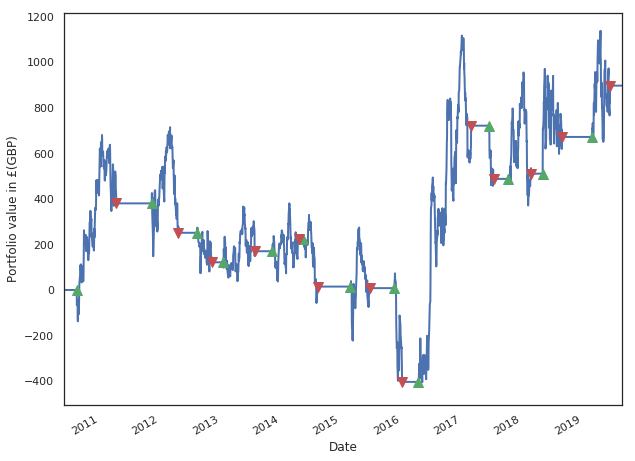

In [21]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in £(GBP)')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2., figsize=(10,8))

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='g')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='r')

# Show the plot
plt.show()

As shown above. The Algo Trading peformance yielded some gains of circa £900 for the £4300 initial outlayed investment.

**One important note**: the gains estimated above do *NOT* includes the dividends yield from this stock.

And this is possibly the most key *important* generator of value for a good stock (see the literarure, e.g. [Motley Fool](https://www.fool.com/investing/dividends-income/2015/08/27/why-dividend-reinvestment-is-one-of-the-smartest-i.aspx).

Future versions of this study will incorporate the effect of dividend yield onto the calculation.

## Predicting Stock Price with Machine Learning (ML)

Lastly, I will explore using two machine learning methods to predict stock prices, namely:
* Linear regression using the *Ridge Regression*
* Gradient Boosting Regressors

The intent of using these ML is to demonstrate a more accurate price stock forecast that would enhance the functionality of an Algo Trader - as shown in the previous section.

I used the notebooks from [FirmAI.org](https://www.linkedin.com/company/firmai/) and [this work](https://colab.research.google.com/drive/19O4w8F-wQ3BqszS0K6Dn2GCG_Z4SLiIO) as open-source code for this study.

### Setting up the ML models
First, setting the initial data parameters.

The algorithm will use batches of 32 prices for each training example, using 32 prices from the past to predict the price on the 33rd day. 

The algo will have  𝑁−32  training examples with  𝑁  being the number of days of downloaded stock data.

And creating a 2D matrix of training samples with each row being the prices of 32 consecutive days in the past, and with the price to predict being the current day.

In [76]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indexes of access for the data
num_samples = len(bp) - window_size
index = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)
print(index)

[[   0    1    2 ...   30   31   32]
 [   1    2    3 ...   31   32   33]
 [   2    3    4 ...   32   33   34]
 ...
 [2303 2304 2305 ... 2333 2334 2335]
 [2304 2305 2306 ... 2334 2335 2336]
 [2305 2306 2307 ... 2335 2336 2337]]


In [77]:
data = bp['Adj Close'].values[indexes] # Create the 2D matrix of training samples
print(data)

[[262.6569519  262.50430298 264.03134155 ... 250.65409851 244.94288635
  245.40103149]
 [262.50430298 264.03134155 264.70324707 ... 244.94288635 245.40103149
  248.69949341]
 [264.03134155 264.70324707 262.84017944 ... 245.40103149 248.69949341
  236.91047668]
 ...
 [536.98547363 533.14984131 534.62512207 ... 488.         488.04998779
  498.75      ]
 [533.14984131 534.62512207 519.28265381 ... 488.04998779 498.75
  502.8999939 ]
 [534.62512207 519.28265381 507.1857605  ... 498.75       502.8999939
  500.20001221]]


`data` is a 2D matrix that has 33 columns features: the training samples are the first 32 columns; the target variable is the last column.

In [78]:
X = data[:,:-1] # each column represents 32 days in the past
y = data [:,-1] # last columnt represents the 33rd day
print(X,y)

[[262.6569519  262.50430298 264.03134155 ... 243.69070435 250.65409851
  244.94288635]
 [262.50430298 264.03134155 264.70324707 ... 250.65409851 244.94288635
  245.40103149]
 [264.03134155 264.70324707 262.84017944 ... 244.94288635 245.40103149
  248.69949341]
 ...
 [536.98547363 533.14984131 534.62512207 ... 494.45001221 488.
  488.04998779]
 [533.14984131 534.62512207 519.28265381 ... 488.         488.04998779
  498.75      ]
 [534.62512207 519.28265381 507.1857605  ... 488.04998779 498.75
  502.8999939 ]] [245.40103149 248.69949341 236.91047668 ... 498.75       502.8999939
 500.20001221]


And finally, we perform a 80/20 split of the dataset. The algorithm will train on 80% of the historical data and will predict the stock price with the reaining 20%.

In [79]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

print(X_train)
print(y_train)

[[262.6569519  262.50430298 264.03134155 ... 243.69070435 250.65409851
  244.94288635]
 [262.50430298 264.03134155 264.70324707 ... 250.65409851 244.94288635
  245.40103149]
 [264.03134155 264.70324707 262.84017944 ... 244.94288635 245.40103149
  248.69949341]
 ...
 [402.32510376 401.74700928 398.67849731 ... 441.37020874 433.81027222
  435.8114624 ]
 [401.74700928 398.67849731 400.94650269 ... 433.81027222 435.8114624
  442.83776855]
 [398.67849731 400.94650269 405.66040039 ... 435.8114624  442.83776855
  446.12863159]]
[245.40103149 248.69949341 236.91047668 ... 442.83776855 446.12863159
 453.77752686]


### ML Method #1 - Ridge Regression
The [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) method from Scikit-learn is a regression model where the loss function is the linear least squares function. 

The algorithm will train first and then perform inference on the test data.

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

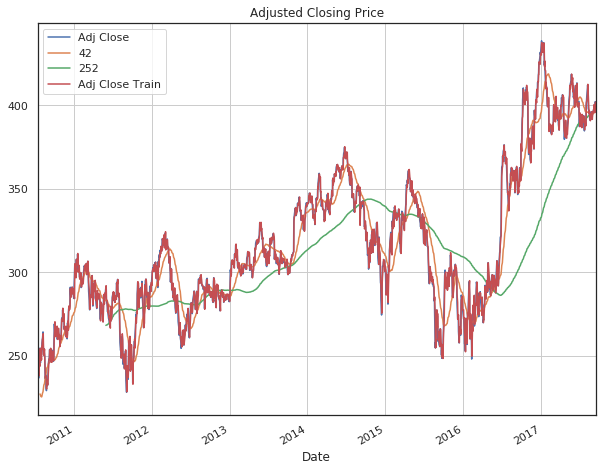

In [81]:
# Plot what it looks like for the training data
df_ridge = bp.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='BP.L', figsize=(10,8), title='Adjusted Closing Price', grid=True)

*Remarks*: hmmm.. the linear regression model is remarkably close to the share price. 

Now testing it on `test data`...

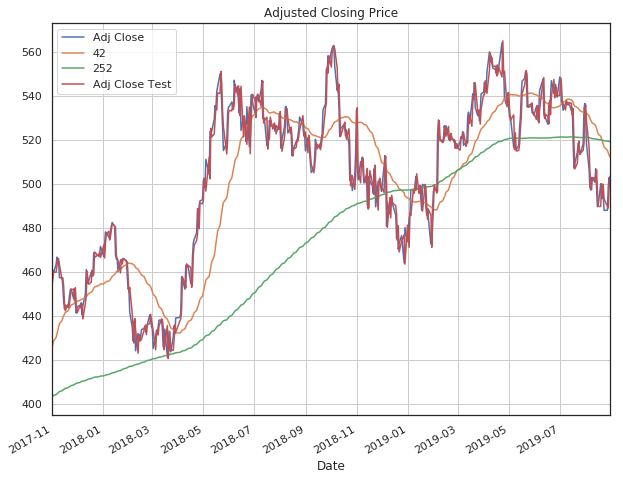

In [82]:
# Same for the test
df_ridge = bp.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='BP.L', figsize=(10,8), title='Adjusted Closing Price', grid=True)

Ok, fair enough. Let's try another regression method...

### Method #2 - Gradient Boosting Trees
Another gradient descent method using decision trees - applied from the [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) library.

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

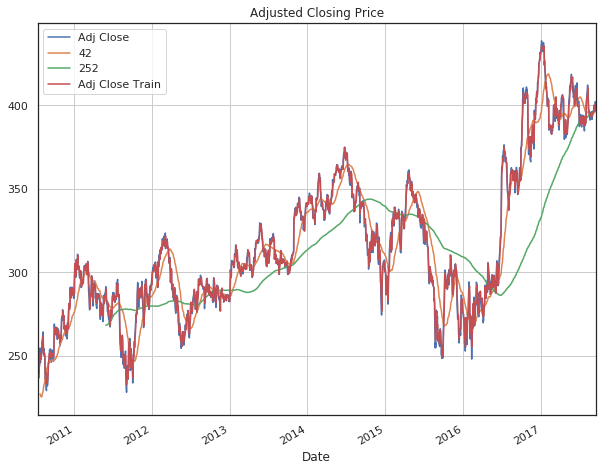

In [84]:
# Plot what it looks like for the training data
df_gb = bp.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='BP.L', figsize=(10,8), title='Adjusted Closing Price', grid=True)

hmmm... major overfitting going on. Fair enough... Checking now the test data:

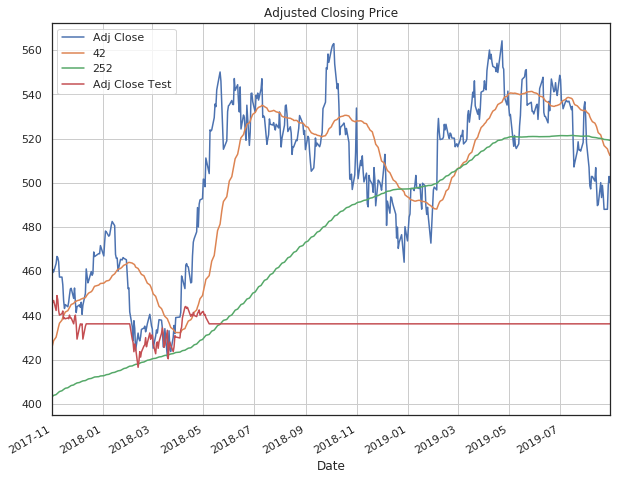

In [85]:
# Same for the test
df_gb = bp.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='BP.L', figsize=(10,8), title='Adjusted Closing Price', grid=True)

The results here fail for the Gradient Boosting Trees at the points of high curvature. Unsure why.


# Discussion & Conclusion
Machine learning regressors are powerful algortithms that can predict the stock price with high degree of accuracy. This contrasts strongly versus the simplified moving average method I implemented in this notebook,

A key limitant on the regressors is that they can lead to frequent trading (on a daily basis). And this is counterproductive for two reasons:
1. For retail investors: there are high fees on buy / selling stocks (on the order of ~$10s per transaction). It is unrealistic to be buying/selling stocks on a daily basis (as per the prediction window of the ML regressors).
2. The regressors don't give an indication when the investor can buy (go long) or sell (and go short) the stock.

A more comprehensive approach will be to use more advanced financial analytics techniques for automatic algo trading. The library [pyfolio](https://quantopian.github.io/pyfolio/) from [Quantopian](https://www.quantopian.com/posts) offers such methods - for example the [Round Trip Tear Sheet Example](https://quantopian.github.io/pyfolio/notebooks/round_trip_tear_sheet_example/).

This is just the beginning...
